# Unstructured Data Analytics: Project 1
Team members: Amulya Saridey, Debleena Das, Ella Akl, Malavika Prasad, Kinjal Doshi

**TASK 1 & 2: FETCH 5-6k OF THE NEWEST COMMENTS POSTED ON EDMUNDS.COM AND EXTRACT TO .CSV FILE**

Forum link: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p330

In [3]:
# Import packages for ChromeDriver
!pip install selenium
!apt-get -q update # To update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
from selenium import webdriver
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize the driver
driver = webdriver.Chrome('chromedriver', options=chrome_options)

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
chromium-chromedriver i

In [4]:
# Import all other necessary packages

import pandas as pd
import re
import nltk
import csv
import itertools
import operator
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from itertools import chain
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Extract the comments and save to a csv file**
# Forum link: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p330

In [5]:
df_comments = pd.DataFrame(columns = ['date','user_id','comments']) 

for page in range(330,435): # Grabs comments from pages 330- 445 (approximately 5250 comments)
  driver.get(f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page}')

  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")

  comment_ids = []
  for i in ids:
    comment_ids.append(i.get_attribute('id'))

  for x in comment_ids:
      # Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      # Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      # Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      
      comment = (user_message.text).lower()

      # Remove blockquotes from user_message, don't include them in comments
      comment_element = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
      blockquote = comment_element.find_elements_by_class_name('UserQuote')
      if blockquote: # If it exists, replace blockquote with an empty string
        comment = comment.replace(blockquote[0].text, '')
                                    
      # Adding date, userid and comment for each user in a dataframe    
      df_comments.loc[len(df_comments)] = [date,userid,comment]
    
# Some text clean-up
df_comments = df_comments.copy()
df_comments = df_comments.replace(r'\n',' ', regex=True)
df_comments = df_comments.replace(r'\t',' ', regex=True)
df_comments = df_comments.replace(r', ',' ', regex=True)

print(f"{df_comments.shape} comments were scraped.")

# Save comments to a csv
df_comments.to_csv('comments.csv', index=False)

(5250, 3) comments were scraped.


In [7]:
# Read the cleaned car models and brands csv
car_model_brand = pd.read_csv("car_models_and_brands.csv", names=["model", "brand"])

In [8]:
# Replace the models with the brands in each comment
new_comments = [] # List to store the new comments
for i in range(len(df_comments['comments'])):
  comment_split = str(df_comments['comments'][i]).split(' ') 

  for j in range(len(comment_split)): # Loop through each word in the comment
    for k in range(len(car_model_brand['model'])):
      if comment_split[j] == car_model_brand['model'][k]: # If the current word matches a brand in the list
        comment_split[j] = comment_split[j].replace(comment_split[j], car_model_brand['brand'][k]) # Replace the word with the brand
  
  new_comments.append(" ".join(comment_split))

In [32]:
# Create a new column in the DataFrame to store the new comments from the previous cell
df_comments["filtered_comments"] = new_comments
df_comments.to_csv('filtered_comments.csv', index=False)

**TASK 3: FILTER OUT STOPWORDS & GET THE TOP 10 CAR BRANDS BASED ON FREQUENCY**

In [10]:
stop_words = set(stopwords.words('english'))
symbols = ["...", "``", "’", "''", "n't", "'s",".", ",", ";", ":", "?", "!", "$", "#", "@", "%", "^", "^", "&", "*", "(", ")", "-", "=", "+", "{", "}", "[", "]", "\\", "/", "'", "`", "~", "<", ">"]


In [11]:
# Filter out the stopwords and symbols
filtered_comments = [] # List to store the comments after being cleaned

for c in df_comments['filtered_comments']:
  word_tokens = word_tokenize(c)

  filtered_sentence1 = [w for w in word_tokens if not w in stop_words]
  filtered_sentence2 = []

  for w in filtered_sentence1:
    if w not in symbols:
      filtered_sentence2.append(w)

  filtered_comments.append(filtered_sentence2)

In [12]:
# Get the word counts for each brand
# Exclude the repeat mentions in the same comment
brands = list(set(car_model_brand['brand']))
brand_counts = pd.DataFrame(brands, columns = ['brand'])
brand_counts['count'] = 0 # Create a new column in the DataFrame to keep track of the brand counts

for comment in filtered_comments: # Loop through each comment
  mentioned_brands = [] # List to keep track of the brands already mentioned in a comment - to prevent counting repeats
  for word in comment: # Loop through each word
    for i in range(len(brands)): # Loop through each brand
      if word == brands[i]: 
        if word not in mentioned_brands:
          # If word matches a brand, increment the brand in the DataFrame
          # and add word to mentioned_brands
          # Note: this will exclude all repeat mentions
          brand_counts.loc[brand_counts['brand'] == word, 'count'] += 1
          mentioned_brands.append(word)

brand_counts= brand_counts[1:]
brand_counts

,brand,count
1,toyota,226
2,mercedes,278
3,lincoln,92
4,audi,941
5,kia,141
6,sedan,295
7,infiniti,278
8,suzuki,1
9,mitsubishi,2
10,pontiac,21


**TASK A: TOP 10 BRANDS BY FREQUENCY**

In [13]:
# Get the top 10 brands
top_10_brands = brand_counts.nlargest(10, 'count')
top_10_brands

,brand,count
13,bmw,1293
4,audi,941
21,acura,592
19,honda,475
6,sedan,295
2,mercedes,278
7,infiniti,278
17,volkswagen,269
18,cadillac,255
1,toyota,226


**TASK A: LIFT CALCULATION**

In [14]:
# Convert brand and its associated frequency into lists
brand_list = list(top_10_brands['brand'])
freq_brand = list(top_10_brands['count'])

In [15]:
# Find the combination of brand pairs occurring in the same comment and save it to a list
pair_list = []
for brand in range(0, len(brand_list)):
  for brand2 in range(brand+1, len(brand_list)):
    pair_list.append([brand_list[brand], brand_list[brand2]])

In [16]:
# Calculate lift
samples = df_comments.shape[0]

def calcLift(brand1, brand2):
  # Getting the frequency of brand 1 in each comment
  brand1freq = sum(df_comments.apply(lambda x: brand1 in x['filtered_comments'], axis=1)) 
  # Getting the frequency of brand 2 in each comment
  brand2freq = sum(df_comments.apply(lambda x: brand2 in x['filtered_comments'], axis=1))
  # Getting the frequency of brand 1 and brand 2 in each comment
  bothBrandFreq = sum(df_comments.apply(lambda x: brand1 in x['filtered_comments'] and brand2 in x['filtered_comments'], axis=1))
  # Applying the lift formula
  lift = float(bothBrandFreq*samples)/(float(brand1freq)*(float(brand2freq))) 
  return lift

# A dictionary to save all lift values
lift_dict ={}

# Passing each pair of brands into the lift calculation function 
for combo in pair_list:
  brand1, brand2 = combo[0], combo[1]
  lift_value= calcLift(brand1, brand2)

  lift_dict[brand1, brand2] = lift_value # Saving the lift value to the dictionary


In [17]:
# Converting the dictionary to a dataframe to display in a table format
lift_df = pd.DataFrame(columns=brand_list, index=brand_list)

for value in lift_dict: # Populating the table with the appropriate lift values
  brand1, brand2 = value
  lift_df.loc[brand1, brand2] = lift_dict[brand1, brand2]

lift_df

,bmw,audi,acura,honda,sedan,mercedes,infiniti,volkswagen,cadillac,toyota
bmw,NaN,1.7201,1.28125,1.02754,1.7281,2.59764,1.84682,1.05047,1.81343,1.29543
audi,NaN,NaN,1.96889,1.59788,1.7684,3.12889,2.60185,2.37421,2.66215,1.77987
acura,NaN,NaN,NaN,3.30373,2.15154,2.6153,3.95044,1.11644,2.54391,1.67447
honda,NaN,NaN,NaN,NaN,2.02395,1.41263,1.96263,1.98213,1.28725,3.1453
sedan,NaN,NaN,NaN,NaN,NaN,2.40184,2.51482,1.1205,2.02429,1.29543
mercedes,NaN,NaN,NaN,NaN,NaN,NaN,4.08337,1.23827,4.12088,1.58228
infiniti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2425,3.2817,2.1169
volkswagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982594,2.34454
cadillac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02856
toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**TASK A: MDS PLOT**





In [18]:
# Dissimilarity matrix 
dis_matrix_df = pd.DataFrame(columns=brand_list, index=brand_list)

for i,j in lift_dict: # For each lift value in the dictionary, find the dissimilarity value
  dissimilarity_matrix = 1/lift_df[j][i] 
  dis_matrix_df[i][i]= 0
  dis_matrix_df[j][j]= 0
  dis_matrix_df[j][i] = dissimilarity_matrix
  
dis_matrix_df

,bmw,audi,acura,honda,sedan,mercedes,infiniti,volkswagen,cadillac,toyota
bmw,0,0.581361,0.780485,0.973195,0.578672,0.384965,0.541471,0.951954,0.551442,0.771943
audi,NaN,0,0.507902,0.62583,0.565484,0.319602,0.384342,0.421193,0.375636,0.561838
acura,NaN,NaN,0,0.302688,0.464783,0.382366,0.253136,0.895701,0.393095,0.597202
honda,NaN,NaN,NaN,0,0.494084,0.707897,0.50952,0.504508,0.776848,0.317935
sedan,NaN,NaN,NaN,NaN,0,0.416348,0.397643,0.892457,0.494,0.771943
mercedes,NaN,NaN,NaN,NaN,NaN,0,0.244896,0.807579,0.242667,0.632
infiniti,NaN,NaN,NaN,NaN,NaN,NaN,0,0.804832,0.30472,0.472388
volkswagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.01771,0.426522
cadillac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.49296
toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [19]:
size = dis_matrix_df.shape # Populating the dissimilarity values in each row of the table 
for j in range(size[0]):
      for i in range(size[0]):
            dis_matrix_df.iloc[i,j]=dis_matrix_df.iloc[j,i]
dis_matrix_df

,bmw,audi,acura,honda,sedan,mercedes,infiniti,volkswagen,cadillac,toyota
bmw,0,0.581361,0.780485,0.973195,0.578672,0.384965,0.541471,0.951954,0.551442,0.771943
audi,0.581361,0,0.507902,0.62583,0.565484,0.319602,0.384342,0.421193,0.375636,0.561838
acura,0.780485,0.507902,0,0.302688,0.464783,0.382366,0.253136,0.895701,0.393095,0.597202
honda,0.973195,0.62583,0.302688,0,0.494084,0.707897,0.50952,0.504508,0.776848,0.317935
sedan,0.578672,0.565484,0.464783,0.494084,0,0.416348,0.397643,0.892457,0.494,0.771943
mercedes,0.384965,0.319602,0.382366,0.707897,0.416348,0,0.244896,0.807579,0.242667,0.632
infiniti,0.541471,0.384342,0.253136,0.50952,0.397643,0.244896,0,0.804832,0.30472,0.472388
volkswagen,0.951954,0.421193,0.895701,0.504508,0.892457,0.807579,0.804832,0,1.01771,0.426522
cadillac,0.551442,0.375636,0.393095,0.776848,0.494,0.242667,0.30472,1.01771,0,0.49296
toyota,0.771943,0.561838,0.597202,0.317935,0.771943,0.632,0.472388,0.426522,0.49296,0


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


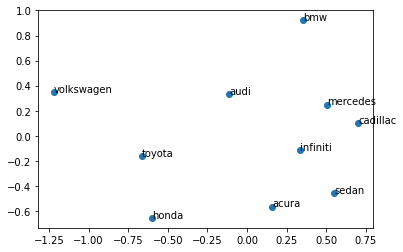

In [20]:
# Defining X to be the dissmilarity value
X = dis_matrix_df

mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)

x = []
y=[]
for i in range(len(X_2d)):
  x.append(X_2d[i][0])
  y.append(X_2d[i][1])

plt.scatter(x,y)
plt.show
# Plotting the mds plot using the dissimilarity matrix
for brand, x, y in zip(brand_list, x, y):
    plt.annotate(brand, (x,y))
        

**TASK B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?**

Based on the lift analysis between our top 10 brands, we found that *Mercedes*  and  *Cadillac* have the highest association, with a **lift of 4.12**. Both of these brands are also mentioned in our top 10 brands, with a frequency of **275** and **255** respectively. Both Mercedes and Cadillac are known to exude luxury and power, and can be seen as competitors in that sphere. However, it was interesting to see how closely associated they were in our analysis. Looking at Mercedes, it is known to have more expensive cars, possibly due to their engineering and design, compared to Cadillac’s cars. There are also some Mercedes cars that are known to be more powerful, especially among the AMG models. Cadillac, on the other hand, rose significantly in popularity much earlier on, and is now trailing behind other luxury car brands, including Mercedes, BMW, and Audi, which were also listed higher in our ranking of top 10 brands. In addition, Mercedes seems to be extremely well-known on a global scale, but Cadillac is more popular within the United States, Canada, and China. This implies that Cadillac has a lot of room to grow in order to remain competitive with the other luxury brands. They may have to implement production and marketing strategies that could expand its cars into a wider market. For instance, the reason behind high Cadillac sales in China is because General Motors assembles the majority of Cadillac cars within China, instead of importing them. Based on this past success and its close association with Mercedes in our analysis, it would be extremely beneficial for Cadillac to expand into other markets, especially larger ones, such as Europe and India. In addition, Cadillac could focus on staying current with the SUV/hybrid trend, and expand their car lineup within that area. Mercedes has been very successful in terms of expanding to global markets. One aspect they could focus on is car pricing, and trying to make some of the models more affordable to a larger population.

**TASK C: What are 5 most frequently mentioned attributes of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You don’t have to do a sentiment analysis for this assignment**

In [41]:
# List of common attributes or most sought after attributes for cars
attribute_words = ["power", "good looks", "price", "smooth", "automatic", "manual", "suspension",
                   "economic", "value", "premium", "cheaper", "front wheel drive", "turbo", "turbocharged",
                   "wheelbase", "wheels", "alloy", "alloy wheels", "cruise", "control", "cruise control",
                   "keyless", "ignition", "keyless ignition", "navigation", "gps", "engine",
                   "front engine", "engines", "engineering", "hatchback", "audio", "interior", 
                   "exterior", "trim", "off road", "off-road", "reliability", "cylinder", "cylinders",
                   "pricing", "reliability", "styling", "smoothness", "extra power", "performance",
                   "performance pack standard", "pack", "standard", "ultimate", "driving", "ultimate driving machine",
                   "comfortable", "seats", "heated seats", "sports", "technology", 
                   "tech", "powertrain", "hybrid", "torque", "transmission", "speed", "auto", 
                   "functionality", "carbon fiber", "motorsport", "doors", "sound", "system", 
                   "dynamics", "agility", "precise handling", "twin turbo", "turbocharger", "cylinders", "cargo",
                   "design", "throttle", "gears"]

In [42]:
attr_dict = {} # Dictionary to store attributes and associated counts

df_comments_copy = df_comments.copy()

for brand in brands:
  attr_list = []
  for comments in df_comments_copy['filtered_comments']:
    for attribute in attribute_words:
      if (attribute in comments and brand in comments):
        attr_list.append(attribute)
        attr_dict[attribute] = len(attr_list)


In [43]:
# Convert dictionary into DataFrame
attri_df = pd.DataFrame(list(attr_dict.items()), columns =['Attributes','Count of Attributes']).sort_values(by=('Count of Attributes'), ascending=False)
attri_df

,Attributes,Count of Attributes
70,agility,1972
66,turbocharged,1004
57,twin turbo,989
50,throttle,978
24,design,977
...,...,...
74,turbocharger,13
69,extra power,9
42,smoothness,8
20,pricing,8


In [57]:
# Get the top 5 brands/attribute pairs
pair_list = []

top_5_brands = brand_counts.nlargest(6, 'count')

top_5_attr=attri_df.nlargest(5, 'Count of Attributes')

brand_list = list(top_5_brands['brand'])
brand_list.remove('sedan')
attr_list = list(top_5_attr['Attributes'])
for brand in brand_list:
  for attr in attr_list:
    pair_list.append([brand, attr])

In [58]:
# Calculate lift
samples = df_comments.shape[0]

def calcLift2(brand, attr):
  # Getting the frequency of the brand in each comment
  brandfreq = sum(df_comments.apply(lambda x: brand in x['filtered_comments'], axis=1)) 
  # Getting the frequency of attribute in each comment
  attrfreq = sum(df_comments.apply(lambda x: attr in x['filtered_comments'], axis=1))
  # Getting the frequency of brand and attribute in each comment
  bothFreq = sum(df_comments.apply(lambda x: brand in x['filtered_comments'] and attr in x['filtered_comments'], axis=1))
  # Applying the lift formula
  lift = float(bothFreq*samples)/(float(brandfreq)*(float(attrfreq))) 
  return lift

# A dictionary to save all lift values
lift_dict ={}

# Passing each pair of brands into the lift calculation function 
for combo in pair_list:
  brand, attr = combo[0], combo[1]
  lift_value= calcLift2(brand, attr)

  lift_dict[brand, attr] = lift_value # Saving the lift value to the dictionary


In [59]:
# Converting the dictionary to a dataframe to display in a table format
lift_df = pd.DataFrame(columns=attr_list, index=brand_list)

for value in lift_dict: # Populating the table with the appropriate lift values
  brand, attr = value
  lift_df.loc[brand, attr] = lift_dict[brand, attr]

lift_df

,agility,turbocharged,twin turbo,throttle,design
bmw,0.95943,0.697767,1.59905,2.13207,1.4527
audi,2.54114,0.462026,1.27057,2.07056,2.03866
acura,6.20079,1.50322,0,1.83727,2.24209
honda,1.33114,1.9362,0,0,2.46674
mercedes,0,3.24675,0,1.32275,2.32042


The top 5 brands in descending order are: BMW, Audi, Acura, Honda, Mercedes.

1. BMW
2. Audi
3. Acura
4. Honda
5. Mercedes   

The top attributes for these brands are as follows:
1. BMW: Throttle
2. Audi: Agility
3. Acura: Agility
4. Honda: Design
5. Mercedes: Turbocharged



**TASK D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive)**

# **Product** **Manager**:

1. **BMW**: 
The most associated attribute word is "*throttle*", as seen from the lift analysis table above. In a standard car, the throttle system controls the air entering the engine by way of a butterfly valve that responds to your foot pressing the throttle pedal. That's not what happens in a BMW with the Valvetronic system. The current throttle system in BMW's is more efficient in terms of air delivery and results in improved fuel economy. Hence, the product manager should continue to implement their strategy for this product. However, there's a low mention of BMW with the attribute "*turbocharged*" in the comments. The product manager should focus on improving the turbocharged engines in their cars to make the brand more attractive in order to expand to a larger consumer base. Also, there's more mentions of "*twin turbo*" with BMW. The managers should strategize and focus on possibly replacing turbocharged engines with twin turbo engines for their cars.

2. **Audi**: 
Given that Audi is a luxury brand, it is normal that "*agility*" is the most common attribute for it. However, there is not much relation of the brand with the attribute "*turbocharged*". Audi has offered electric turbos in other markets for a few years, but the technology is only just now coming to the United States in 2020. This explains why there's a low correlation, since we extracted the latest comments from the forum. However, we think that Audi should give more importance to this feature, even though it’s in the early stages of implementation, as it has a huge potential to drive the brand to success.

3. **Acura**:
Out of the top 5 brands, Acura is highly associated with the "*agility*" feature/attribute. In fact, it outcompetes the other brands because of this high correlation. However, there is no mention of Acura with "*twin turbo*". The first model that had the twin turbo feature was introduced in 2016, which is pretty recent. Acura would need to advertise this attribute more, so that they can outcompete Mercedes and Honda who are also having low association with twin turbo.

4. **Honda and Mercedes**:
Consumers highly associate Mercedes and Honda with "*design*”, but based on our lift analysis, Honda is slightly more associated with design. Product managers for Mercedes's upcoming model years should focus on improving the quality of their models' interiors, paying particular attention to features like more leg room and sufficient head room for tall passengers--just as Honda does. In addition, it is surprising that Honda has low relation with "*agility*", given that Acura is a division of Honda and it has the most relation with agility. Both Mercedes and Honda's product managers should improve their cars to adapt to "*twin turbo*" engines as well. 





#**Advertising/Marketing Manager**

1. **BMW**:
In terms of marketing strategies, BMW should continue to enhance the connection between its cars and the ideas of power and luxury. For instance, since one of the highest lift values was with the attribute “twin turbo”, BMW advertising could focus on showcasing the efficiency and performance of the engines. On the luxury side, BMW could enhance more of the interior design, look, and feel aspect of the cars. Another advertising strategy would be to combine both and showcase the synergy between power and luxury. Together, these approaches would cater to a wider consumer base, from those who are interested in the mechanics of the car, to those who appreciate the added luxury.

2. **Audi**:
Audi only seems to have quite moderate lift associations with the top 5 attributes, compared to the other brands. Based on this lift analysis, the best strategy would be to capitalize on agility and design, since those had higher associations. Advertising strategies could focus on emphasizing Audi’s sleek exterior and interior design, along with showcasing parts related to agility, such as wheels and steering motion.

3. **Acura**:
Based on our lift analysis, the highest association we found was between Acura and the attribute “agility”. This would imply that Acura should focus their marketing and advertising on car features that describe this attribute. To people who are more familiar with cars, this could be done by showcasing the cars’ engine performance and efficiency. For those who are more into the looks and comfort of the car, advertising could focus on more commonly known attributes associated with agility, such as the wheels and steering wheel maneuvers.

4. **Honda and Mercedes**:
In terms of advertising, Mercedes and Honda would probably have very similar strategies, especially when showcasing the design and features of their cars. However, based on our lift values, the association between these two brands and design is very close. This would mean that both brands would have to gain some competitive edge in advertising design-related attributes of the car. Mercedes does have a much higher association with “turbocharged” and “throttle”, implying that these could be possible attributes that it can highlight in their advertisements to have that competitive edge over Honda. Honda, on the other hand, would really need to maximize on showcasing agility and design in a fresh and sleek way, in order to overcome the popularity and demand of its strong competitor, Mercedes.






**TASK E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**




In [27]:
# Specifying a list of aspirational phrases
aspirations = ['want to', 'need to', 'love to','like to', 'hope to', 'desire to', 'would like', 'really want', 'would love', 'dream car', 'dream of', 'dreamt of', 'wish to', 'thinking to', "can't wait to", 'nice to have', 'nice to own', 'looking to', 'wanting to', 'future car', 'buy', 'aspire to']

In [60]:
# Dictionary to store all aspirational phrases related to a brand
asp_dict = {}
df_comments_copy = df_comments.copy()

for brand in brands: # Look at each brand in brand list
  phrase_list=[] # Create a phrase list for each brand to store phrases related to it
  for comments in df_comments_copy["filtered_comments"]: # Go through each comment
    for phrase in aspirations: # Go through each phrase in aspirations
      if (phrase in comments and brand in comments): # If the phrase and brand occur in the same comment
        phrase_list.append(phrase) # Add the phrase associated with a brand to the phrase list 
        asp_dict[brand]=len(phrase_list) # Count the elements in the phrase list for each brand and add that to the main asp_dictionary
        


In [29]:
# Change the asp_dict to a dataframe to easily sort for the highest count
aspirations_df= pd.DataFrame(list(asp_dict.items()), columns =['Brand','Count of Aspirational Phrases']).sort_values(by=('Count of Aspirational Phrases'), ascending=False)

# Setting brand column as the index
phrase_df=aspirations_df.set_index('Brand') 

In [30]:
# Defining the sample size for lift calculation
samples = df_comments_copy.shape[0]

def calcLift(brand, asp_phrase_freq, bothFreq):
  # Calculates the number of times the brand appears in a comment
  brandfreq = sum(df_comments_copy.apply(lambda x: brand in x['filtered_comments'], axis=1))  
  
  # Lift formula
  lift = float(bothFreq*samples)/(float(brandfreq)*(float(asp_phrase_freq))) 
  return lift

lift_dict = {} # Dictionary to store a brand and its lift value

aspirations_df_copy = aspirations_df.copy()
# Loop through each brand in the apsirations dataframe 
for brand in aspirations_df_copy['Brand']:
  asp_phrase_freq = phrase_df.sum() # Get the total count of the aspiration phrase column
  bothFreq = phrase_df.loc[brand, 'Count of Aspirational Phrases'] # Gets the total count for each brand 
  lift_value = calcLift(brand, asp_phrase_freq, bothFreq) # Passing values to the lift function

  lift_dict[brand] = lift_value # Add the brand and the lift value to the lift dict

In [31]:
# Create a dataframe to store brand and lift value -- from the lift_dict
asp_lift_df = pd.DataFrame.from_dict(lift_dict, orient='index', columns = ['Lift Value']).sort_values(by=('Lift Value'), ascending=False)
asp_lift_df.head(10)

,Lift Value
suzuki,1.646801
chevrolet,1.124644
pontiac,1.122819
mercury,1.097867
saturn,1.097867
mercedes,0.941029
ford,0.916719
hyundai,0.891717
chrysler,0.878294
nissan,0.861403


For this task, we chose aspirational phrases like 'want to', 'need to', 'love to', 'like to', 'hope to', 'desire to' to represent a user's want/need to actually own or buy a car of a specific brand. In order to do this, we found the frequency of the brand and each of the aspirational phrases occurring together in each comment. From this, we were able to find possible pairs of brand and aspirational phrase, which helped us to calculate the lift value. Based on the lift values, we surprisingly found that ***Suzuki*** was the most aspirational brand. This is closely followed by **Chevrolet**, **Pontiac**, **Mercury** and **Saturn**. 
Looking at our top 10 brands from Task A, we see that Mercedes was a part of it yet, Suzuki wasn't. We are assuming that the lift ratio becomes bigger when dividing by a small number such as low brand frequency and low aspirational phrase frequency occurring in the same comment. Regarding the business implications, Suzuki can continue to use its current marketing techniques in order to maximize on market perception of their cars. Due to the close lift values of Chevrolet and Pontiac, there may be higher competition between those brands. In a business perspective, Chevrolet and Pontiac would also have to implement unique strategies in order to outcompete one another. This could also apply for Mercury and Saturn which have the same lift value.